In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [18]:
img = cv2.imread('tiny_check.jpg')

In [19]:
print type(img)

<type 'numpy.ndarray'>


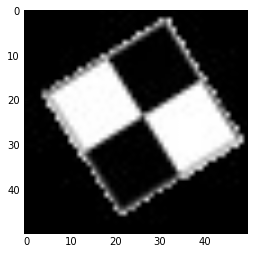

In [20]:
plt.imshow(img)
plt.show()

In [21]:
print np.amax(img)

255


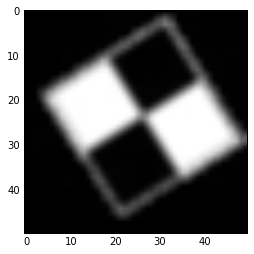

In [25]:
# for quick reference - cv2.GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]]) → dst
#compare with matlab usage: 
blurred = cv2.GaussianBlur(img, (3,3), 2)
plt.imshow(blurred)
plt.show()

In [26]:
#What else do we need?
#We need to define transforms and apply transforms in a good way

In [48]:
#cv2.getRotationMatrix2D(center, angle, scale) 
rm = cv2.getRotationMatrix2D((25,25), 15, 0.5)
print rm

[[  0.48296291   0.12940952   9.69068911]
 [ -0.12940952   0.48296291  16.16116524]]


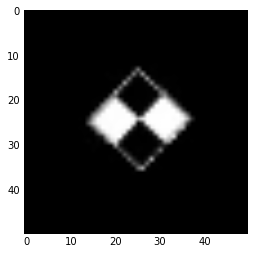

In [49]:
#cv2.warpAffine(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]]) 
rotated = cv2.warpAffine(img, rm, (50,50))
plt.imshow(rotated)
plt.show()

In [ ]:
#how to make inverse transform in cv2?
#cv2.invertAffineTransform(M[, iM]) → iM
#cv.Transform(src, dst, transmat, shiftvec=None) → None

rotrans

In [50]:
def jacobi(du, dv, XData, YData, tau, mode):
    """ jacobi() will calculate the jacobi matrix.
    ------------------------------input--------------------------------------
    du:           m-by-n matrix, derivative along x-axis;
    dv:           m-by-n matrtix, derivative along y-axis;
    UData:        1-by-2 vector, X-range of the image.
    VData:        1-by-2 vector, Y-range of the image.
    tfm_matrix:   3-by-3 matrix, transformation matrix.
    mode:         one of 'affine', 'affine_notranslation', 'homography',
    'homography_notranslation'
    ------------------------------output-------------------------------------
    J:            m-by-n-by-p tensor, jacobi matrix.

    """
    [m, n] = du.shape
    [X0, Y0] = np.meshgrid(range(XData[0],XData[1]+1), range(YData[0],YData[1]+1))

    if mode == 'euclidean':
        tau = [tau]
        J = np.zeros((m, n, 1))
        J[:,:,0] = du * (- X0 * np.sin(tau[0]) - Y0 * np.cos(tau[0])) + dv * (X0 * np.cos(tau[0]) - Y0 * np.sin(tau[0]))
    #if mode == 'affine':  
    
    return J
        

In [58]:
img = cv2.imread('pisa.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE)
print img.shape

(639, 480)


In [66]:
from scipy.ndimage.filters import sobel
from skimage import transform
from skimage import data, io, filters
XData = [0, 479]
YData = [0, 638]
du = sobel(img, 0)
dv = sobel(img, 1)

In [67]:
J = jacobi(du, dv, XData, YData, 20, 'euclidean')

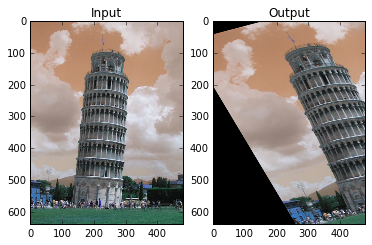

In [70]:
img = cv2.imread('pisa.jpg')
rows,cols,ch = img.shape
 
pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])
 
M_aff = cv2.getAffineTransform(pts1,pts2)
M = np.eye(3)
M[:2,:] = M_aff
 
dst = cv2.warpPerspective(img,M,(cols,rows))
 
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [219]:
img = cv2.imread('pisa.jpg')
  
rows,cols,ch = img.shape
M = np.asarray([[1., 0, 0.5], [0.2, 1, 0], [0, 0.001, 1]])
center= np.zeros((2,1))
center[0] = rows/2
center[1] = cols/2
trans = np.eye(3,3)
trans[:2,2] = -center.reshape(2,)
print trans
print center
MM = M.dot(trans) #TRANSLATION DOESNOT GUARANTEE THAT IT WOULD FIT - IT IS ONLY FOR FINAL FIT, DOES NOT CHANGE transf
#dust = np.zeros((3000,3000,3))
#dst = cv2.warpAffine(img, trans, (2*cols,2*rows))
dst = cv2.warpPerspective(img, M, (4*cols,4*rows), dst=dust, flags=cv2.WARP_INVERSE_MAP)
#trans = np.eye(2,3)
#trans[:2,2] = -center.reshape(2,)
#dst = cv2.warpAffine(dst, trans, (4*cols,4*rows))


[[   1.    0. -319.]
 [   0.    1. -240.]
 [   0.    0.    1.]]
[[ 319.]
 [ 240.]]


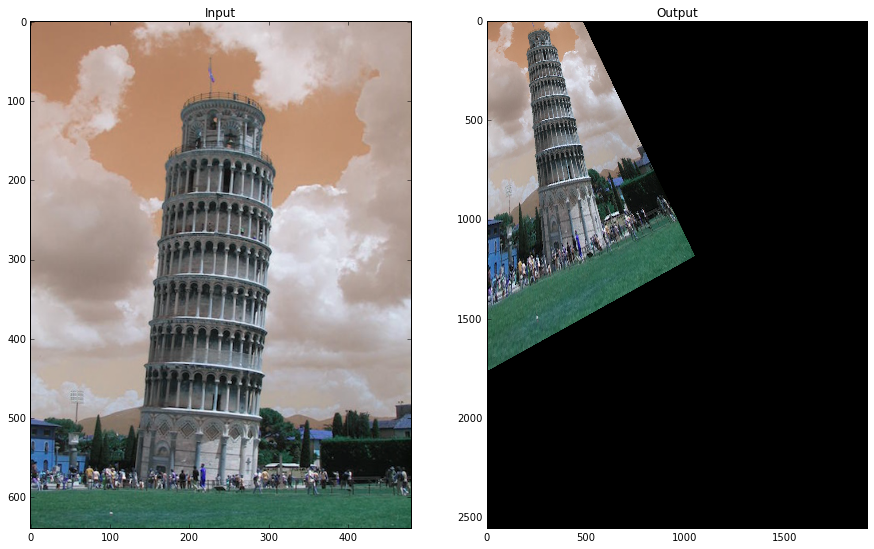

In [220]:
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [272]:
def search_borders(image, trf_matrix):
    left_up = np.array((0,0, 1))
    left_bot = np.array((0, img.shape[0], 1))
    right_up = np.array((img.shape[1], 0, 1))
    right_bot = np.array((img.shape[1], img.shape[0], 1))
    vertexes = [left_up, left_bot, right_up, right_bot]

    new_vertexes = []

    for ver in vertexes:
        new_ver = trf_matrix.dot(ver)
        new_vertexes.append(new_ver)

    new_vertexes = np.array(new_vertexes) 
    new_vertexes[:,0] /= new_vertexes[:,2]
    new_vertexes[:,1] /= new_vertexes[:,2]
    new_vertexes[:,2] /= new_vertexes[:,2]

    x_min = np.min(new_vertexes[:,0])
    x_max = np.max(new_vertexes[:,0])
    y_min = np.min(new_vertexes[:,1])
    y_max = np.max(new_vertexes[:,1])
    
    return x_min, x_max, y_min, y_max

In [286]:
from copy import deepcopy
img = cv2.imread('pisa.jpg')
  
rows,cols,ch = img.shape
M = np.asarray([[1., 0, 0.5], [0.2, 1, 0], [0, 0.001, 1]])
center= np.zeros((2,1))
center[0] = rows/2
center[1] = cols/2
trans = np.eye(3,3)
trans[:2,2] = -center.reshape(2,)
print trans
print center
#MM = M.dot(trans) #TRANSLATION DOESNOT GUARANTEE THAT IT WOULD FIT - IT IS ONLY FOR FINAL FIT, DOES NOT CHANGE transf
#dust = np.zeros((3000,3000,3))
#dst = cv2.warpAffine(img, trans, (2*cols,2*rows))
trans2 = deepcopy(trans)
trans2[:2,2] = center.reshape(2,)
MM = np.linalg.inv(M).dot(trans)
dst = cv2.warpPerspective(img, MM, (cols,rows))#, dst=dust)
#trans = np.eye(2,3)
#trans[:2,2] = -center.reshape(2,)
#dst = cv2.warpAffine(dst, trans, (4*cols,4*rows))

x_min, x_max, y_min, y_max = search_borders(img, MM)

x_scale = img.shape[1] / (x_max - x_min)
y_scale = img.shape[0] / (y_max - y_min)

trans_back = np.eye(3)
trans_back[0,2] = -x_min
trans_back[1,2] = -y_min

trans_backscale = np.eye(3)
trans_backscale[0,0] = x_scale
trans_backscale[1,1] = y_scale


res = np.linalg.inv(M).dot(vec)
img_1 =  cv2.warpPerspective(img, trans_backscale.dot(trans_back.dot(MM)), (cols,rows), dst=dust)
print res

[[   1.    0. -319.]
 [   0.    1. -240.]
 [   0.    0.    1.]]
[[ 319.]
 [ 240.]]
[[-0.49995   ]
 [ 0.09999   ]
 [ 0.99990001]]


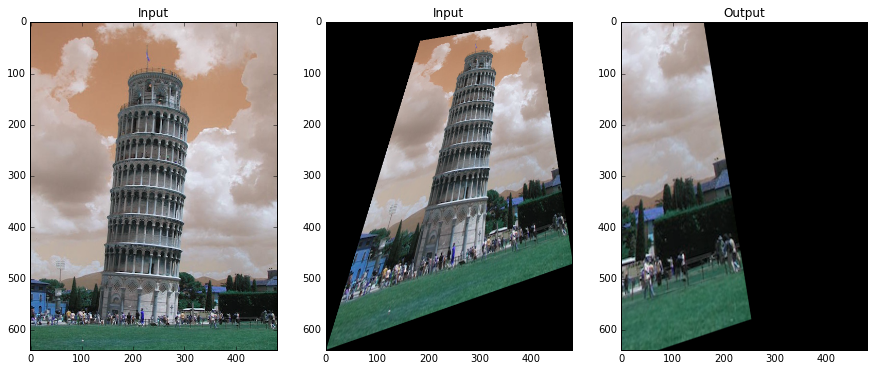

In [287]:
plt.figure(figsize=(15,15))
plt.subplot(131),plt.imshow(img),plt.title('Input')
plt.subplot(132),plt.imshow(img_1),plt.title('Input')
plt.subplot(133),plt.imshow(dst),plt.title('Output')
plt.show()

In [317]:
def polina_transform(input_image, tfm_matrix, UData, VData, XData, YData):
    
    final = np.eye(3)
    
    #first, translate to a new center:
    u_trans = np.eye(3)
    u_trans[0,2] = UData[0]
    u_trans[1,2] = VData[0]
    
    #then apply the transform
    M = np.eye(3)
    M = np.linalg.inv(tfm_matrix)
    
    #then do a transform according to XData and YData
    x_trans = np.eye(3)
    x_trans[0,2] = -XData[0]
    x_trans[1,2] = -YData[0]
    
    final = x_trans.dot(M).dot(u_trans)
    
    img_1 =  cv2.warpPerspective(input_image, final, (np.sum(np.abs(XData)).astype(int),np.sum(np.abs(YData)).astype(int)))
    
    plt.imshow(img_1)
    plt.show()

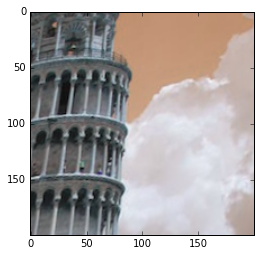

In [318]:
M = np.asarray([[1., 0, 0.5], [0.2, 1, 0], [0, 0.001, 1]])
UData = np.asarray([-318, 320])
VData = np.asarray([-239, 240])
XData = np.asarray([-100, 100])
YData = np.asarray([-100, 100])

polina_transform(img, M, UData, VData, XData, YData)